In [1]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset
import pandas as pd
import numpy as np

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")


2025-09-08 14:34:55.304443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757334895.327316  238831 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757334895.334687  238831 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757334895.354411  238831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757334895.354431  238831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757334895.354433  238831 computation_placer.cc:177] computation placer alr

Loading dataset...
Dataset loaded in 0.09 seconds


# Cutouts


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    im = axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")

# LC visualization

30 sources in the light curves 


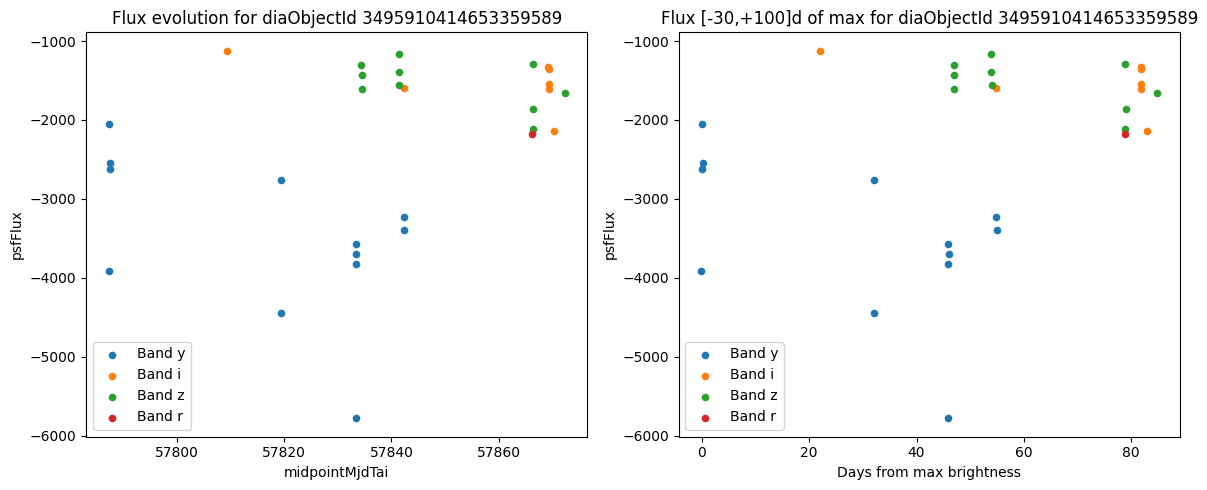

In [3]:
dataset.lightcurves.plot_lightcurve(dia_object_id=3495910414653359589)

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
sample_dia_source_id = dataset.cutouts[first_visit].ids[10]

print(f"Performance comparison for diaSourceId: {sample_dia_source_id}")
print("=" * 60)

# Method 1: Lightcurve only
print("\nMethod 1: Lightcurve columns only")
start_time = time.time()
data_lc_only = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=False)
time_lc_only = time.time() - start_time

if data_lc_only:
    print(f"Success: {data_lc_only['num_sources']} sources, {len(data_lc_only['lightcurve'])} LC points")
    print(f"Time: {time_lc_only:.3f}s")
else:
    print("Failed")

print("-" * 60)

# Method 2: Lightcurve + cutouts
print("\nMethod 2: Lightcurve + cutouts")
start_time = time.time()
data_full = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=True)
time_full = time.time() - start_time

if data_full:
    print(f"Success: {data_full['num_sources']} sources, {len(data_full['cutouts'])} cutouts")
    print(f"Time: {time_full:.3f}s")
else:
    print("Failed")

print("=" * 60)

# Performance summary
if data_lc_only and data_full:
    speedup = time_full / time_lc_only
    print(f"\nSpeedup: {speedup:.1f}x faster (lightcurve-only)")
    print(f"Time saved: {time_full - time_lc_only:.3f}s")

In [ ]:
# Plot all cutouts
if data_full and data_full['cutouts']:
    cutouts = data_full['cutouts']
    lightcurve = data_full['lightcurve']
    
    # Sort by time if available
    if 'diaSourceId' in lightcurve.columns and 'midpointMjdTai' in lightcurve.columns:
        time_map = dict(zip(lightcurve['diaSourceId'], lightcurve['midpointMjdTai']))
        sorted_ids = sorted(cutouts.keys(), key=lambda x: time_map.get(x, 0))
    else:
        sorted_ids = list(cutouts.keys())
    
    n_cutouts = len(cutouts)
    cols = min(8, n_cutouts)
    rows = (n_cutouts + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if n_cutouts == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, src_id in enumerate(sorted_ids):
        im = axes[i].imshow(cutouts[src_id], cmap='RdYlGn', origin='lower')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    for i in range(n_cutouts, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Cutouts for object {data_full["object_id"]} ({n_cutouts} total)')
    plt.tight_layout()
    plt.show()
else:
    print("No cutouts available")

# Lc inference

Discovering data files...
Data discovery completed in 0.01s: 862 cutout visits, 862 feature visits, 1 lightcurve paths
Loaded SNN inference data: 3856539 total lightcurves
  SNN processed: 485 lightcurves
  Not processed (failed filtering): 3856054 lightcurves
  Processing rate: 0.0%

SNN Inference Source Count Statistics:
  Mean sources per lightcurve: 17.4
  Min sources: 10
  Max sources: 116

VALIDATING SNN FILTERING CONSISTENCY
Checking 100 SNN-processed lightcurves against filtering criteria...
Loaded lightcurve index with 3856539 objects
Validation passed: All sampled objects meet filtering criteria


SNN-processed objects: 485
Non-SN: 19 (3.9%)
Supernova: 466 (96.1%)

Uncertainty Statistics:
Mean SN probability uncertainty: 0.152
High uncertainty objects (std > 0.1): 350

High-confidence SN (mean prob > 0.7): 342
High-confidence + Low uncertainty (std < 0.05): 33

Top 5 candidates (by mean probability):
NOTE: Lightcurve statistics shown below are from the current HDF5 files,
   

/sps/lsst/users/rbonnetguerrini/ML4transients/src/ML4transients/data_access/data_loaders.py:1639: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


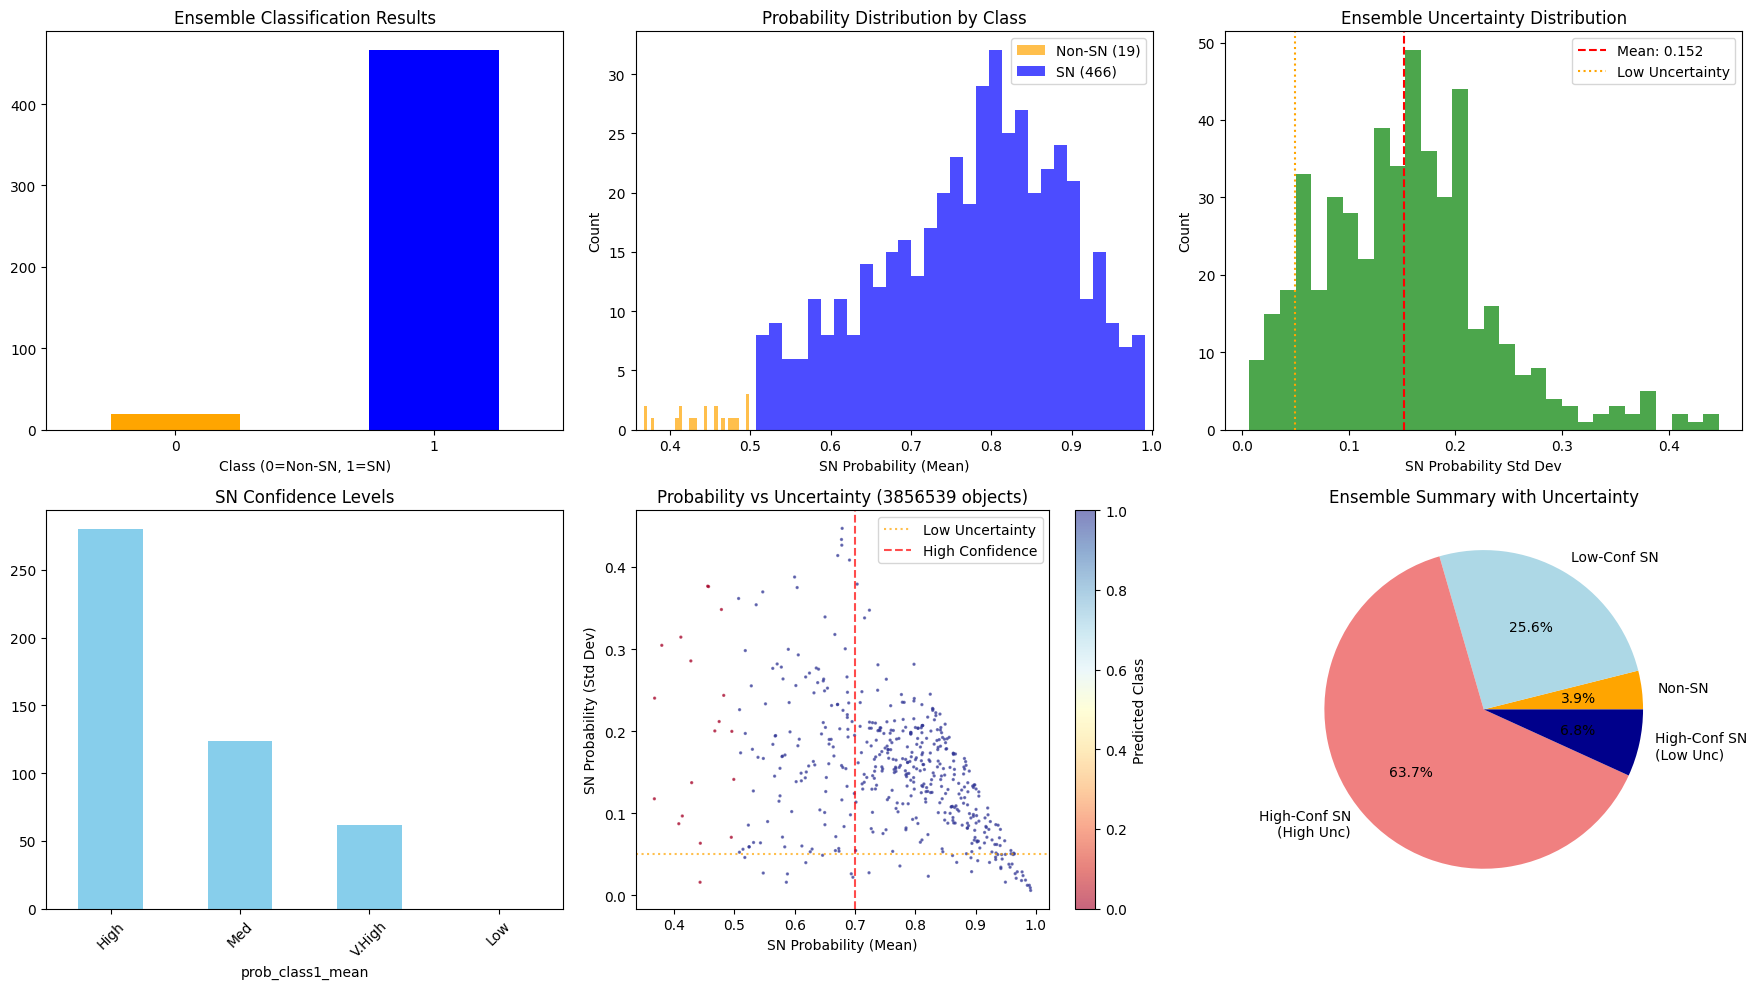


Ensemble Summary:
SNN-processed objects: 3856539
Total objects in dataset: 3856539
High-confidence SN candidates: 342
High-conf + Low uncertainty: 33
Mean uncertainty: 0.152
Objects with high uncertainty (>0.1): 350


,diaObjectId,prob_class0_mean,prob_class1_mean,prob_class0_std,prob_class1_std,pred_class,n_sources_at_inference
0,3495804861537058817,NaN,NaN,NaN,NaN,-1,NaN
1,3495804861537058818,NaN,NaN,NaN,NaN,-1,NaN
2,3495804861537058819,NaN,NaN,NaN,NaN,-1,NaN
3,3495804861537058820,NaN,NaN,NaN,NaN,-1,NaN
4,3495804861537058821,NaN,NaN,NaN,NaN,-1,NaN
...,...,...,...,...,...,...,...
3856534,3495840045909147953,NaN,NaN,NaN,NaN,-1,NaN
3856535,3495840045909147954,NaN,NaN,NaN,NaN,-1,NaN
3856536,3495840045909147955,NaN,NaN,NaN,NaN,-1,NaN
3856537,3495840045909147956,NaN,NaN,NaN,NaN,-1,NaN


In [2]:
dataset.lightcurves.inference_snn

Discovering data files...
Data discovery completed in 0.01s: 862 cutout visits, 862 feature visits, 1 lightcurve paths
Found 91 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 2365
Loaded lightcurve index with 3856539 objects


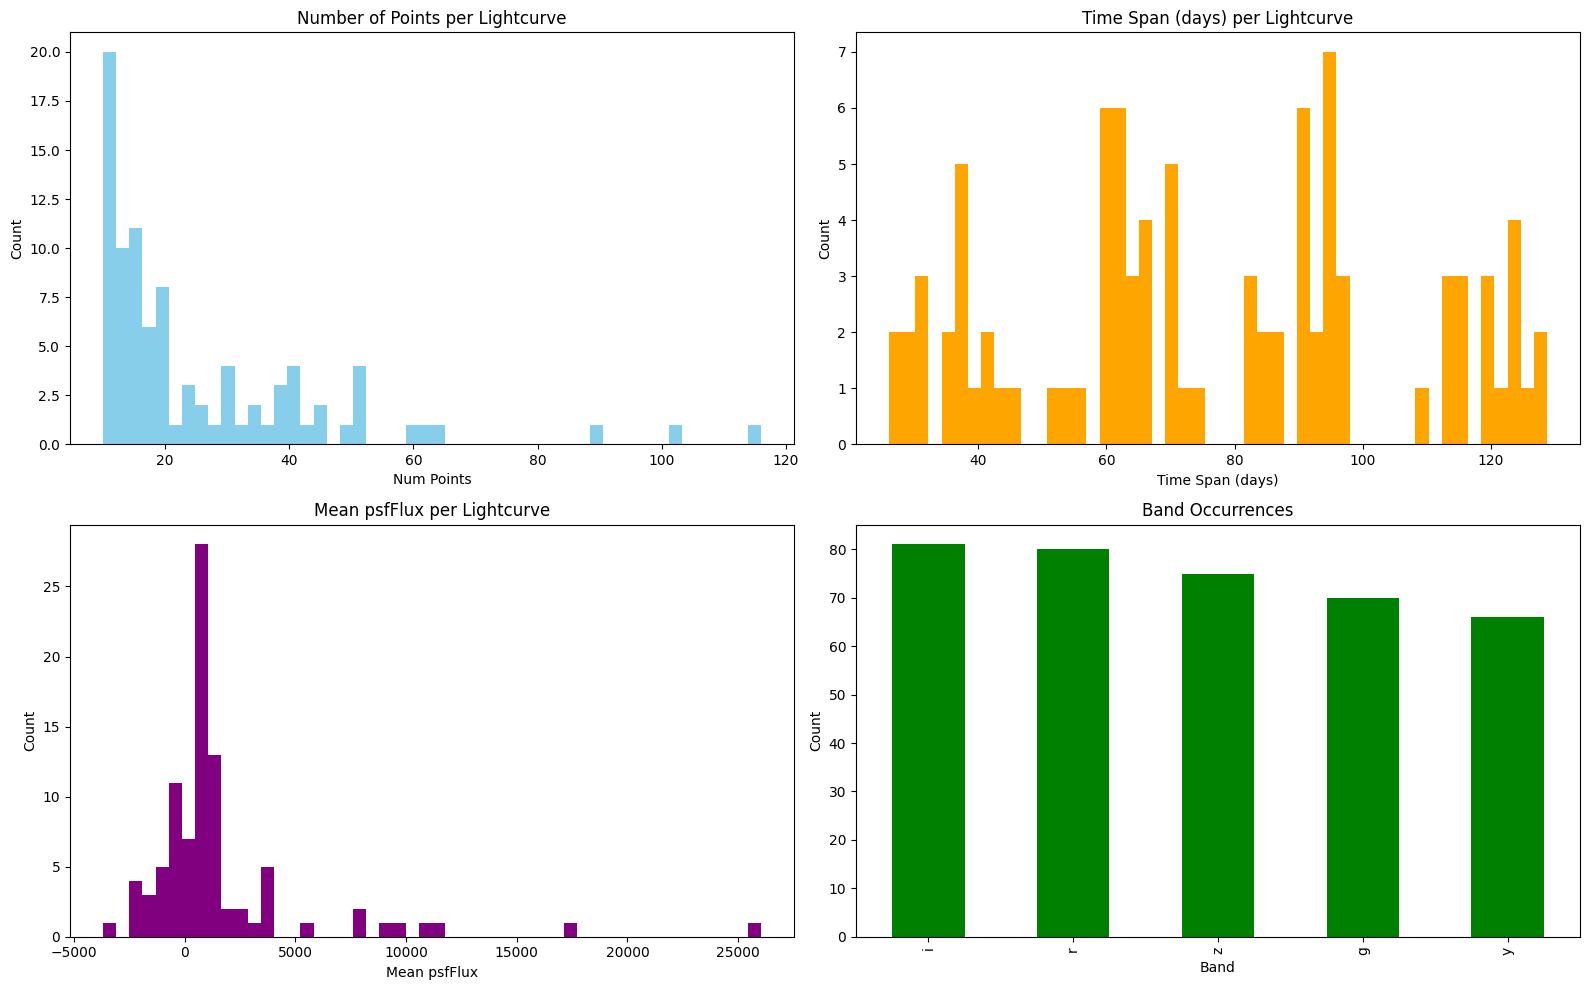

{'num_lightcurves': 91, 'num_points': {'mean': 25.98901098901099, 'median': 18.0, 'std': 19.90388691704393, 'min': 10, 'max': 116}, 'time_span_days': {'mean': 76.30699325174342, 'median': 70.92310768518655, 'std': 29.147426405727636, 'min': 26.0359696874948, 'max': 128.7836921296257}, 'mean_psf_flux': {'mean': 1642.5222932737254, 'median': 734.0259344738307, 'std': 4071.1486228665517, 'min': -3693.8077353326335, 'max': 26038.366907915002}, 'bands': {'unique': ['z', 'g', 'i', 'r', 'y'], 'counts': {'i': 81, 'r': 80, 'z': 75, 'g': 70, 'y': 66}}}


In [2]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.8, std_threshold=0.1))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

In [21]:
dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv3", prob_threshold=0.8, std_threshold=0.1)

Found 91 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 2365
Saving 2365 high-confidence SN sources to mini-dataset.
Skipping lightcurve_index.h5 (already exists in output)
Skipping diasource_patch_index.h5 (already exists in output)
No high-confidence sources found in patch_9813_9.h5
No high-confidence sources found in patch_9813_2.h5
No high-confidence sources found in patch_9813_52.h5
No high-confidence sources found in patch_9813_75.h5
No high-confidence sources found in patch_9813_40.h5
No high-confidence sources found in patch_9813_24.h5
No high-confidence sources found in patch_9813_20.h5
No high-confidence sources found in patch_9813_38.h5
No high-confidence sources found in patch_9813_21.h5
No high-confidence sources found in patch_9813_18.h5
No high-confidence sources found in patch_9813_71.h5
No high-confidence sources found in patch_9813_79.h5
No high-confidence sources found in patch_9813_42.h5
No high-confidence sources found in patch_98